## Project.2 Исследование надёжности заёмщиков

    (yandex_practicum by student@pavel_matushevskiy, Volgograd 2022)


### Описание проекта

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Описание данных

children — количество детей в семье

days_employed — общий трудовой стаж в днях

dob_years — возраст клиента в годах

education — уровень образования клиента

education_id — идентификатор уровня образования

family_status — семейное положение

family_status_id — идентификатор семейного положения

gender — пол клиента

income_type — тип занятости

debt — имел ли задолженность по возврату кредитов

total_income — ежемесячный доход

purpose — цель получения кредита

 ### Импорт библиотек

In [1]:
# подгрузим необходимые для работы библиотеки
import math
import pandas as pd
from pymystem3 import Mystem

### Шаг 1. Импорт данных

In [2]:
df = pd.read_csv("data.csv")
#df = pd.read_csv("/datasets/data.csv")
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


### Наблюдения:

Данные загружены и первично изучены. 

С колонкой  <b>days_employed</b> явно что-то не так: есть отрицательные значения и категория float, 
хотя дни должны быть целыми.
Что касается отрицательных значений - возможно ошибка возникает при передаче данных и минус 
просто надо убрать. Проверим позже.

В столбце  <b>education</b> регистр букв разных размеров, надо привести к единому регистру. 
Можно принудительно "понизить" регистр и во всех остальных категориальных столбцах (на всякий случай).

Доход  <b>total_income</b> почему то данные с точностью до копейки. Хотя вряд ли клиенты так передали данные, и вряд ли нам нужны копейки для расчетов. Можно перевести в целое число int.

Признак <b>children</b> ошибочно содержит также отрицательные значения, с этим надо разобраться. 



### Шаг 2. Предобработка данных.

#### 2.1. Обработка названия столбцов и данных.

Названия столбцов в целом корректные, разве что можно было бы изменить названия для лучшего понимания

In [5]:
# приведем сразу все категориальные признаки к одному регистру для более удобного анализа
df["education"] = df["education"].str.lower()
df["income_type"] = df["income_type"].str.lower()
df["family_status"] = df["family_status"].str.lower()
df["purpose"] = df["purpose"].str.lower()
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [6]:
# посмотрим кол-во пропусков по признакам в датасете:
# все не так и плохо, пропуски всего в двух признаках.
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

#### 2.2. Обработка пропусков

#### 2.2.1. Нужно обработать пропуски признака days_employed
    Отрицательные значения - похоже что ошибка передачи данных (можно убрать минус через abs())
    Тут вопрос в другом: насколько полезен данный признак нам? 
        Может не стоит на него тратить усилия и сразу удалить?
        Изучим этот признак подробней...

In [8]:
# избавимся от отрицательных значений в признаке:
df["days_employed"] = abs(df["days_employed"])
# добавим новый признак years_employed (переведем трудовой стаж в годы)
df["years_employed"] = df["days_employed"]/365
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,years_employed
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04,19351.000000
mean,0.538908,66914.728907,43.293380,0.817236,0.972544,0.080883,1.674223e+05,183.328024
std,1.381587,139030.880527,12.574584,0.548138,1.420324,0.272661,1.029716e+05,380.906522
min,-1.000000,24.141633,0.000000,0.000000,0.000000,0.000000,2.066726e+04,0.066141
25%,0.000000,927.009265,33.000000,1.000000,0.000000,0.000000,1.030532e+05,2.539751
50%,0.000000,2194.220567,42.000000,1.000000,0.000000,0.000000,1.450179e+05,6.011563
75%,1.000000,5537.882441,53.000000,1.000000,1.000000,0.000000,2.034351e+05,15.172281
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06,1100.699727


<AxesSubplot:>

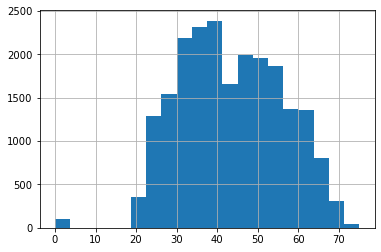

In [9]:
# посмотрим на распределение признака dob_years и years_employed
df["dob_years"].hist(bins=20)

 <div class="alert alert-info"> <b>Правка на комментарий #1:</b> обработаем нулевые значения возраста заемщика, т.к. это явно косяк, который потом может нам подпортить статистику. Используем самый простой вариант: замену медианным значением признака (по всем значениям). Вариант №2: можно было бы сделать более сложный вариант: посчитать медианное значение возраста по группам (категориям), например муж\жен, по профессии, или исходя из трудового стажа. Но т.к. этот признак в дальнейшем на наше исследование не влияет - применим самый простой вариант заполнения нулевых значений. Обработка будет произведена далее по ноутбуку. </div>

In [10]:
# подсчитаем сколкьо у нас нулевых значений. Много, более 5%.
len(df[df["dob_years"] ==0])

101

In [11]:
dob_years_median = df["dob_years"].median()
dob_years_median

42.0

<AxesSubplot:>

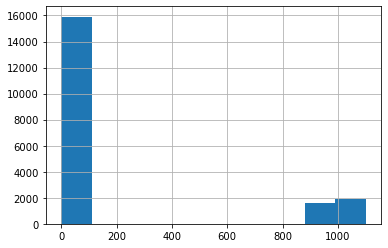

In [12]:
# тут явно какие -то артефакты в значениях, так как распределение years_employed не равномерное
# и выходит за пределы значений возраста клиентов (dob_years)
df["years_employed"].hist(bins=10)

In [13]:
# медианнное значение years_employed/days_employed также выглядят странно.
median_dobs_years = df["dob_years"].median()
print("медианный возраст клиента",median_dobs_years)
median_days_empl = df["years_employed"].median()
print("медианный стаж работы клиента",median_days_empl)
#df["days_employed"] = df["days_employed"].fillna(median_days_empl)

медианный возраст клиента 42.0
медианный стаж работы клиента 6.0115631969279315


Вывод: наверное лучшим простым решением было бы удаление признаков days_employed (и его производный years_employed) чтобы избежать негативного влияния на наши данные при анализе, но в работе аналитика все может пригодиться, поэтому оставим.

In [14]:
#df = df.drop(["years_employed",'days_employed'],1)

 <div class="alert alert-info"> <b> Заполним пропуски в этих признаках медианным значением: </div>

In [16]:
median_years_empl = df['years_employed'].median()
df['years_employed'] = df['years_employed'].fillna(median_years_empl) 
median_days_empl = df['days_employed'].median()
df['days_employed'] = df['days_employed'].fillna(median_days_empl) 
# посмотрим на результат:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
 12  years_employed    21525 non-null  float64
dtypes: float64(3), int64(5), object(5)
memory usage: 2.1+ MB


#### 2.2.2.Нужно обработать пропуски признака total_income

Далее нужно обработать пропуски признака total_income.
Целесообразно в этой ситуации использовать медиану, но не на базе всех данных,
а по категориям: использовать уровень образования и тип занятости.

Для этого напишем функцию, для вычисления медианы для конкретной категории. 

In [17]:
def calc_median(df, education_level, income_type):
    """
    Функция считает медиану по группам признаков
    """
    # ориентируемся на оба параметра
    median = df[(df['education'] == education_level) & (df['income_type'] == income_type)]['total_income'].median()
    # для случая где нет совпадения для двух параметров, предусмотрим рассчет по одному
    if math.isnan(median):
        median = df[df['education'] == education_level]['total_income'].median()
        if math.isnan(median):
            median = df[df['income_type'] == income_type]['total_income'].median()    
    return median

In [18]:
# применим новую функцию для заполнения пропусков пройдясь по категориям уровня
# образования и типа занятости:
for education in df[df['total_income'].isnull()]['education'].unique():
    for income_type in df[df['total_income'].isnull()]['income_type'].unique():
        median = calc_median(df, education, income_type)
        searchRow = (df['education'] == education) & (df['income_type'] == income_type) & (df['total_income'].isnull())
        df.loc[searchRow, 'total_income'] = df.loc[searchRow, 'total_income'].fillna(median)
 

In [19]:
# применим transform и медиану для заполнения пропусков:
df['total_income']= df['total_income'].fillna(df.groupby(['education','income_type'])['total_income'].transform("median"))
# убедимся что код отработал корректно:
df['total_income'].isnull().sum()

0

#### 2.3. Замена типа данных

In [20]:
# Заменим тип total_income на int 
# Поскольку мы в дальнейшем будем категоризировать данные по total_income, 
# то с целочисленными значениями это будет делать проще.
df['total_income'] = df['total_income'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  int64  
 11  purpose           21525 non-null  object 
 12  years_employed    21525 non-null  float64
dtypes: float64(2), int64(6), object(5)
memory usage: 2.1+ MB


#### 2.4. Поиск и обработка дубликатов в данных

In [21]:
# проверим, есть ли дубликаты в таблице
df.duplicated().sum()

71

In [22]:
# дубликаты есть, уберем их:
df = df.drop_duplicates().reset_index(drop=True) 
df.duplicated().sum()

0

Вывод:  
Дубликатов оказалось не так много и их удалось быстро удалить. Причины дубликатов - возможно на 1 человека заполнялось по несколько анкет, а затем вносились в базу.

#### 2.5. Поиск ошибок и аномалий в данных

Обработка других ошибок в данных\
Дополнительно поизучав данные на уровне подсчета уникальных значений (value_counts()) для каждого столбца, был выявлен еще ряд проблем:

children_count содержит значение 20 и -1, хотя отрицательного числа быть не может и 20 сильно выделяется на фоне остальной выборки\
dob_years содержит нулевой возраст\
gender содержит пол XNA\
purpose содержит опечатку - ремонт жильЮ\

Про возможные причины и действия: 
Значение 20 в количестве детей скорее всего опечатка от значения 2,случайно напечатали ноль.
Нулевой возраст быть не может, скорее всего он нам просто неизвестен. Можем заменить медианным значением.
Ошибку пол XNA - заменим самым частым значением (по признаку).
Сборщика данных предупредим о выявленных ошибках, дабы уменьшить их кол-во в будущем.
Исправим эти моменты у себя в датасете.

In [23]:
# в признаке 'children' встречается значение 20 (что нереально) и -1 (тоже анреал).
df['children'].value_counts()

 0     14091
 1      4808
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [24]:
# исправим значение -1 для количества детей  на 1 (скорее всего это описка)
df['children'] = abs(df['children'])
# исправим значение 20 для количества детей на 2 (скорее всего это тех описка), 
# хотя таких случаев много (76)
df['children'] = df['children'].replace(20, 2) 
# Убедимся, что ошибки устранены:
df['children'].value_counts()

0    14091
1     4855
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

In [25]:
# заменим значение 0 на медианное значение в признаке "возраст заемщика":
median_years = df['dob_years'].median()
df['dob_years'] = df['dob_years'].replace(0, median_years) 

In [26]:
# В признаке gender содержится странный "пол" - 'XNA'. 
# Заменим его самым частым значением gender.
most_gender = df['gender'].value_counts().index[0]
df['gender'] = df['gender'].replace('XNA',most_gender) 
df['gender'].value_counts()

F    14175
M     7279
Name: gender, dtype: int64

In [119]:
# изучим подробнее имеющиеся значения признака "цель" кредита:
df['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

 Признак purpose содержит опечатку - "ремонт жильЮ"

In [27]:
# исправим опечатку:
df['purpose'] = df['purpose'].replace('ремонт жилью','ремонт жилья') 

Вывод\
В данных встречаются артефакты и нам стоит об этом предупредить тех, кто готовил данные. Однако их количество вряд ли отразится на статических результатах исследования. Тем не менее, для большей точности, ключевые моменты мы исправили.

### 3. Категоризация данных

#### 3.1. Категоризация признака purpose. Лемматизация

In [28]:
# Используем лемматизацию  (процесс преобразования слова в его базовую форму).
# выделим леммы в значениях столбца с целями получения кредита (purpose)
m = Mystem()
# получим леммы для каждой причины, чтобы дальше проанализировать
# используем словарь, а не список, чтобы дальше это использовать для категоризации
lemmas_dict = dict()
for purpose in df['purpose'].unique():
    lemmas_dict[purpose] = m.lemmatize(purpose)
    
# проанализируем леммы - удалим пробелы, выделим самые часто встречаемые слова
# отсортируем по частоте встречания слов, чтобы получить словарь основных причин
# те слова, что встречаются только один раз, удалим

#для начала проанализируем частоту встречания слов по всем причинам кредита
lemmas_count = dict()
for key, lemmas in lemmas_dict.items():
    for lemma in lemmas:
        if lemma != ' ' and lemma != '\n':
            if not lemma in lemmas_count:
                lemmas_count[lemma] = 1
            else:
                lemmas_count[lemma] += 1
                
#выведем топ встречаемых слов                
for k in sorted(lemmas_count, key=lemmas_count.get, reverse=True):
    if lemmas_count[k] > 2:
        print(k, lemmas_count[k])

покупка 10
недвижимость 10
автомобиль 9
образование 9
жилье 7
с 5
операция 4
на 4
свой 4
свадьба 3
строительство 3
получение 3
высокий 3


In [29]:
lemmas_dict

{'покупка жилья': ['покупка', ' ', 'жилье', '\n'],
 'приобретение автомобиля': ['приобретение', ' ', 'автомобиль', '\n'],
 'дополнительное образование': ['дополнительный', ' ', 'образование', '\n'],
 'сыграть свадьбу': ['сыграть', ' ', 'свадьба', '\n'],
 'операции с жильем': ['операция', ' ', 'с', ' ', 'жилье', '\n'],
 'образование': ['образование', '\n'],
 'на проведение свадьбы': ['на', ' ', 'проведение', ' ', 'свадьба', '\n'],
 'покупка жилья для семьи': ['покупка',
  ' ',
  'жилье',
  ' ',
  'для',
  ' ',
  'семья',
  '\n'],
 'покупка недвижимости': ['покупка', ' ', 'недвижимость', '\n'],
 'покупка коммерческой недвижимости': ['покупка',
  ' ',
  'коммерческий',
  ' ',
  'недвижимость',
  '\n'],
 'покупка жилой недвижимости': ['покупка',
  ' ',
  'жилой',
  ' ',
  'недвижимость',
  '\n'],
 'строительство собственной недвижимости': ['строительство',
  ' ',
  'собственный',
  ' ',
  'недвижимость',
  '\n'],
 'недвижимость': ['недвижимость', '\n'],
 'строительство недвижимости': ['стр

In [30]:
# Создадим новый признак (true_purpose) с основанием для кредита по категориям, 
# которые мы выделили на этапе лемматизации

# напишем функцию:
def make_true_purpose(table_purpose):
    """
    создание нового признака с категоризацией основания для кредита
    """
    #lemmas_dict мы сохраняли ранее
    purpose_lemmas = lemmas_dict[table_purpose]
    if 'недвижимость' in purpose_lemmas or 'жилье' in purpose_lemmas:
        return 'операции с недвижимостью'
    
    if 'автомобиль' in purpose_lemmas:
        return 'операции с автомобилем'
    
    if 'образование' in purpose_lemmas:
        return 'получение образования'
    
    if 'свадьба' in purpose_lemmas:
        return 'проведение свадьбы'
    
    return ''

df['purpose_category'] = df['purpose'].apply(make_true_purpose)
    
#проверим, что никто не остался без категории
df[df['purpose_category'] == '']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,purpose_category


In [31]:
# Изучим результат категоризации кредитов: получились 4 основные категории. 
df['purpose_category'].value_counts()

операции с недвижимостью    10811
операции с автомобилем       4306
получение образования        4013
проведение свадьбы           2324
Name: purpose_category, dtype: int64

In [32]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,purpose_category
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23.116912,операции с недвижимостью
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11.026860,операции с автомобилем
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,15.406637,операции с недвижимостью
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11.300677,получение образования
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,932.235814,проведение свадьбы


#### 3.2. Категоризация признака children

In [33]:
# была идея категоризировать этот признак на 0, 1, 2 и 3+ детей, но отказался от этой идеи.
df['children'].value_counts()

0    14091
1     4855
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

#### 3.3. Категоризация признака total_income

In [34]:
# категоризируем признак total_income
# будем использовать следующие категории:
# до 50, от 50 до 100, от 100 до 150, от 150 до 200, от 200 до 300, от 300 и выше

def make_income_category(total_income):
    """
    функция делает категоризацию по доходу
    """
    if total_income <= 30000:
        return 'E'
    if 30000 < total_income <= 50000:
        return 'D'
    if 50000 < total_income <= 200000:
        return 'C'
    if 200000 < total_income <= 1000000:
        return 'B'
    return 'A'

df['total_income_category'] = df['total_income'].apply(make_income_category)
# проверим, что получилось на выходе:
df['total_income_category'].value_counts()

C    15829
B     5228
D      350
A       25
E       22
Name: total_income_category, dtype: int64

In [35]:
# посмотрим на распределение кредитов по целям-кредита в % долях от общего числа:
df['purpose_category'].value_counts(normalize=True)

операции с недвижимостью    0.503915
операции с автомобилем      0.200708
получение образования       0.187051
проведение свадьбы          0.108325
Name: purpose_category, dtype: float64

# Вывод:  
Судя по уровню дохода, кредит не особо интересен тем, кто зарабатывает очень много, как и тем, кто зарабатывает мало. А вот остальным (в диапазоне от 30001 до 1000000) он интересен. Причем с доходом от 50001 до 200000  - наиболее интересен.  
Кредит не бояться брать те, у кого нет детей, а чем детей больше - тем меньше желающих.  
Больше всего интересуют именно кредиты, связанные с недвижимостью (50% +)

### 3.2. Выделение словарей

In [36]:
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,purpose_category,total_income_category
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23.116912,операции с недвижимостью,B
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11.026860,операции с автомобилем,C
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,15.406637,операции с недвижимостью,C
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11.300677,получение образования,B
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,932.235814,проведение свадьбы,C
5,0,926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,2.537495,операции с недвижимостью,B
6,0,2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,7.888225,операции с недвижимостью,B
7,0,152.779569,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование,0.418574,получение образования,C
8,2,6929.865299,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы,18.985932,проведение свадьбы,C
9,0,2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи,5.996593,операции с недвижимостью,C


По данным у нас напрашиваются два словаря. Более того, у нас уже предусмотрены соответствующие id

education
family_status
Помимо этого, можно вынести отдельно gender и purpose. Но gender не занимает много места и не сильно нужен нам для анализа, по сути столбец вовсе можно удалить. А purpose не отражает реальных категорий, поэтому мы выделяли типы отдельно, поэтому словарь для него выйдет избыточным.

Поэтому остановимся на словарях для education и family_status

In [37]:
# выделим словарь для education:
education_dict = df[['education_id', 'education']]
# удалим дубликаты из словаря
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
# проверим содержимое
education_dict.head(10)

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


In [38]:
education_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   education_id  5 non-null      int64 
 1   education     5 non-null      object
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


In [39]:
# аналогичным образом поступим для family_status
# выделим словарь для family_status:
family_status_dict = df[['family_status_id', 'family_status']]
# удалим дубликаты из словаря
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)
# проверим содержимое
family_status_dict.head(10)

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,не женат / не замужем


In [40]:
# т.к. словари мы сохранили, а id проставлены, удалим столбцы education_level и family_status из основной таблицы
df = df.drop(["education",'family_status'],1)
#посмотрим, остались ли столбцы
df.head()

/var/folders/zy/n21wvl254wj5bjdrpk0q3z000000gn/T/ipykernel_85340/2518220148.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(["education",'family_status'],1)


,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,purpose_category,total_income_category
0,1,8437.673028,42,0,0,F,сотрудник,0,253875,покупка жилья,23.116912,операции с недвижимостью,B
1,1,4024.803754,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,11.026860,операции с автомобилем,C
2,0,5623.422610,33,1,0,M,сотрудник,0,145885,покупка жилья,15.406637,операции с недвижимостью,C
3,3,4124.747207,32,1,0,M,сотрудник,0,267628,дополнительное образование,11.300677,получение образования,B
4,0,340266.072047,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,932.235814,проведение свадьбы,C


In [41]:
df.debt.value_counts()

0    19713
1     1741
Name: debt, dtype: int64

### 4. Ответы на вопросы

#### 4.1. Вопрос: Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [42]:
# функция, что посчитает нам отношение в процентах, будем использовать для ответов на все вопросы
def make_proportion(pdSerises):
    return str(round((pdSerises.sum() / pdSerises.count()) * 100, 2)) + '%'

In [43]:
# построим сводную таблицу для ответа на вопрос
data_pivot_children = df.pivot_table(index=['children'], values=["debt"], aggfunc=['sum', 'count', make_proportion])
# сортируем, чтобы сразу видеть у кого ситуация лучше
data_pivot_children = data_pivot_children.sort_values(by=('make_proportion', 'debt'))
data_pivot_children

,sum,count,make_proportion
,debt,debt,debt
children,,,
5,0,9,0.0%
0,1063,14091,7.54%
3,27,330,8.18%
1,445,4855,9.17%
2,202,2128,9.49%
4,4,41,9.76%


In [44]:
# построим сводную таблицу для ответа на вопрос
data_pivot_children = df.pivot_table(index=['children'], values=["debt"], aggfunc=['sum', 'count', "mean"])
# сортируем, чтобы сразу видеть у кого ситуация лучше
data_pivot_children = data_pivot_children.sort_values(by=('mean', 'debt'))
data_pivot_children

,sum,count,mean
,debt,debt,debt
children,,,
5,0,9,0.000000
0,1063,14091,0.075438
3,27,330,0.081818
1,445,4855,0.091658
2,202,2128,0.094925
4,4,41,0.097561


Вывод:  
У заемщика без детей вероятность возникновения задолженности чуть ниже, чем если дети есть.   Что любопытно, когда детей много, задолженность возникает примерно на том же уровне. В остальных случаях вероятность просрочки выше.
Но  разница не такая уж большая (между 1-2 ребенка). 

#### 4.2.Вопрос: Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [45]:
# поскольку мы до этого удаляли из основных данных текстовые значения family_status, тут необходимо их вернуть
df_with_family_status = df.merge(family_status_dict, on='family_status_id', how='left')
# построим сводную таблицу для ответа на вопрос (по фрейму со значениями из словаря)
data_pivot_family = df_with_family_status.pivot_table(index=['family_status'], values=["debt"], aggfunc=['sum', 'count', "mean"])
# Отсортируем для удобства
data_pivot_family = data_pivot_family.sort_values(by=('mean', 'debt'))
data_pivot_family

,sum,count,mean
,debt,debt,debt
family_status,,,
вдовец / вдова,63,959,0.065693
в разводе,85,1195,0.071130
женат / замужем,931,12339,0.075452
гражданский брак,388,4151,0.093471
не женат / не замужем,274,2810,0.097509


Вывод:  
Интересно, что вдовец/вдова и люди в разводе имеют наименьший риск просрочки.  Возможно, это связно с тем, что одиночке легче планировать и контролировать свои финансы, меньше непредвиденных расходов.

А вот самая "опасная" категория - неженатые и состоящие в гражданском браке.  
Мораль: безответсвенный человек - безответственен во всем!)

#### 4.3.Вопрос: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [46]:
# построим сводную таблицу для ответа на вопрос
data_pivot_income = df.pivot_table(index=['total_income_category'], values=["debt"], aggfunc=['sum', 'count', "mean"])
# сортируем, чтобы сразу видеть у кого ситуация лучше
data_pivot_income = data_pivot_income.sort_values(by=('mean', 'debt'))
data_pivot_income

,sum,count,mean
,debt,debt,debt
total_income_category,,,
D,21,350,0.060000
B,364,5228,0.069625
A,2,25,0.080000
C,1352,15829,0.085413
E,2,22,0.090909


Вывод:  
Тут мы видим, смешанную картину: меньше всего просрочка у обеспеченных людей (от  201 до 1000 тыс. руб.) и у тех, у кого доход небольшой (от 31 до 50 тыс.руб.).  
При чем первые  не особо любят оформлять заявки на кредит, а вторые наоборот - одна из массовых категорий.  
Самые обеспеченные заемщики (1 млн.руб. доход) - тоже не очень любят брать кредит и с платежной дисциплиной у них на 33% хуже.  
Самая массовая категория (от 51 до 200 тыс. руб.)- можно сказать средний класс- в целом плохо дисциплинирована, хуже только категория бедных, с доходом до 30 тыс. рублей.  
Стоит заметить, что разница между самой дисциплинированной категорией и наоборот - почти 50%.

#### 4.4.Вопрос: Как разные цели кредита влияют на его возврат в срок?

In [47]:
# построим сводную таблицу для ответа на вопрос
data_pivot_purpose = df.pivot_table(index=['purpose_category'], values=["debt"], aggfunc=['sum', 'count', "mean"])
# сортируем:
data_pivot_purpose = data_pivot_purpose.sort_values(by=('mean', 'debt'))
data_pivot_purpose

,sum,count,mean
,debt,debt,debt
purpose_category,,,
операции с недвижимостью,782,10811,0.072334
проведение свадьбы,186,2324,0.080034
получение образования,370,4013,0.092200
операции с автомобилем,403,4306,0.093590


Вывод:  
Выгоднее всего давать кредиты на недвижимость, а автомобиль и образование - более рисковые виды кредита. Хотя разница не такая уж большая, но стоит того, чтобы учесть ее при расчете риска невозврата кредита.

#### 4.5.Вопрос (bonus): Как пол заемщика влияет на его возврат в срок?

In [48]:
# построим сводную таблицу для ответа на вопрос
data_pivot_gender = df.pivot_table(index=['gender'], values=["debt"], aggfunc=['sum', 'count', "mean"])
# сортируем
data_pivot_gender = data_pivot_gender.sort_values(by=('mean', 'debt'))
data_pivot_gender

,sum,count,mean
,debt,debt,debt
gender,,,
F,994,14175,0.070123
M,747,7279,0.102624


Вывод:  
Выгоднее всего давать кредиты женщинам, они лучше дисциплинированы и процент просрочки ниже.

#### 4.6.Вопрос (bonus): Как род занятия заемщика влияет на его возврат в срок?

In [49]:
# построим сводную таблицу для ответа на вопрос
data_pivot_type = df.pivot_table(index=['income_type'], values=["debt"], aggfunc=['sum', 'count', "mean"])
# сортируем
data_pivot_type = data_pivot_type.sort_values(by=('mean', 'debt'))
data_pivot_type

,sum,count,mean
,debt,debt,debt
income_type,,,
предприниматель,0,2,0.000000
студент,0,1,0.000000
пенсионер,216,3829,0.056412
госслужащий,86,1457,0.059025
компаньон,376,5078,0.074045
сотрудник,1061,11084,0.095724
безработный,1,2,0.500000
в декрете,1,1,1.000000


Вывод:  
Выгоднее всего давать кредиты пенсионерам и госслужащим, у них просрочки мало (наверное связано со стабильным доходом).
У студентов и предпринимателей  - вообще просрочка нулевая, а в декрете и безработным лучше вообще не давать!) Шутка, данные по этим категориям нерепрезентативны в силу малочисленности выборки по этим категориям. Можно лишь говорить об обьективной оценке категорий "сотрудник", "компаньон", "пенсионер" и "госслужащий".

### 5. Общий вывод

Самый идеальный заемщик - это человек без детей или имеющий 5 детей, состоящий или состоявший в официальных отношениях, имеющий уровень дохода выше среднего и берущий деньги на недвижимость.

"Разброс" просроченных выплат по каждой из категорий примерно одинаковый. В среднем, это диапазоны от 6 до 9 процентов. В остальном разница в абсолютных цифрах не такая большая. Однако в относительных разница составляет в среднем 2-3 процента, что означает разницу в вероятности просрочки платежа на 20% и более.

Детально по категориям:
Влияние наличия детей на вероятность просрочки платежа
Интересное наблюдение: у семей с 5 детей - нулевая просрочка (хотя таких случаев всего 9 и это не показатель), и это можно было бы взять на заметку.

По наличию детей
Нет детей - 7.54%
1 ребенок - 9.17%
2 ребенка - 9.49%
3 ребенка - 9.49%
4 ребенка - 9.49%
5 ребенка - 0%
Абсолютная разница между "нет детей" и "4 ребенка" - 1.95%
Относительная разница между "нет детей" и "4 ребенка" - 20.54%

Влияние семейного положения на вероятность просрочки платежа
По семейному положению
вдовец / вдова - 6.57%
в разводе - 7.11%
женат / замужем - 7.55%
гражданский брак - 9.35%
не женат / не замужем - 9.75%
Абсолютная разница между минимальным и максимальным значением - 3.18%
Относительная разница между минимальным и максимальным значением - 32,6%

Влияние уровня дохода на просрочку платежа
По уровню дохода
До 30000 - 9.09%
От 30001 до 50000 - 6.00%
От 50001 до 200000 - 8.54%
От 200001 до 1000000 - 6.96%
От 1000001  - 8.0%
Абсолютная разница между минимальным и максимальным значением - 3.09%
Относительная разница между минимальным и максимальным значением - 51.5%

Влияние цели кредита на вероятность возврата кредита в срок
По цели кредита
недвижимость - 7.23%
свадьба - 8.0%
образование - 9.22%
автомобиль - 9.36%
Абсолютная разница между минимальным и максимальным значением - 2.13%
Относительная разница между минимальным и максимальным значением - 22.76%

Влияние пола заемщика на вероятность возврата кредита в срок
женщины - 7.01%
мужчины - 10.3%
Абсолютная разница между минимальным и максимальным значением - 3.29%
Относительная разница между минимальным и максимальным значением - 46.93%

Влияние рода занятия на вероятность возврата кредита в срок
 
предприниматель - 0.00%
студент	- 0.00%
пенсионер -	5.64%
госслужащий	- 5.90%
компаньон - 7.40%
сотрудник - 9.57%
безработный	 - 50.0%
в декрете -100%

Для анализа честно будет учитывать только категории пенсионер,госслужащий,компаньон,сотрудник
Абсолютная разница между минимальным и максимальным значением - 3.93%
Относительная разница между минимальным и максимальным значением - 69.7%

Таким образом, несмотря на схожий в процентном отношении разброс значений, наибольшее влияние на вероятность просрочки показывает именно семейное положение. Во вторую очередь, следует обращать внимание на уровень дохода. Наименьшее влияние оказывают цели кредита и наличие детей.
Из сильных факторов можно также отметить пол заемщика и род деятельности, но они не являются темой нашего иследования.